In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from sklearn.metrics import roc_curve, roc_auc_score

INFOLDER = "./logs_augm_no_augm/nl2bash/"

metrics = [os.path.join(INFOLDER, x, "version_0", "metrics.csv") for x in os.listdir(INFOLDER) if x.endswith("_csv")]
metrics.extend([os.path.join(INFOLDER, x, "metrics.csv") for x in os.listdir(INFOLDER) if x.endswith("xgb_onehot")])

In [2]:
metrics_df = {}
for m in metrics:
    basedir = m.replace(r"\metrics.csv", "").replace(r"\version_0","").replace(INFOLDER, "")
    key = basedir.replace("_csv", "")
    metrics_df[key] = pd.read_csv(m)

In [3]:
metrics_df.keys()

dict_keys(['augm_cnn', 'augm_mean_transformer', 'augm_mlp_onehot', 'not_augm_cnn', 'not_augm_mean_transformer', 'not_augm_mlp_onehot', 'augm_xgb_onehot', 'not_augm_xgb_onehot'])

In [4]:
def collect_metric(metrics_df, metric_name="val_f1", how="last"):
    assert how in ["last", "best", "max"]
    df = pd.DataFrame()
    for key, value in metrics_df.items():
        series = value[metric_name]
        # drop nan value
        series = series.dropna()
        if how == "last":
            df[key] = [series.iloc[-1]]
        else:
            df[key] = [series.max()]
    return df


In [5]:
metrics_to_keep = metrics_df['augm_xgb_onehot'].columns.tolist()
df = pd.concat([collect_metric(metrics_df, metric_name=x, how="last") for x in metrics_to_keep]).T
df.columns = metrics_to_keep
results_df = df.T
results_df

,augm_cnn,augm_mean_transformer,augm_mlp_onehot,not_augm_cnn,not_augm_mean_transformer,not_augm_mlp_onehot,augm_xgb_onehot,not_augm_xgb_onehot
train_tpr,0.975219,0.907401,0.999647,0.041667,0.000000,0.000000,1.000000,1.000000
train_f1,0.995943,0.997371,0.994208,0.006296,0.000000,0.002856,1.000000,1.000000
train_acc,0.996652,0.997838,0.995257,0.884399,0.958740,0.744263,1.000000,1.000000
train_auc,0.999936,0.999813,0.999989,0.506804,0.579643,0.302096,1.000000,1.000000
val_tpr,1.000000,0.000000,0.729958,0.000000,0.270042,0.000000,0.888889,0.222222
val_f1,0.692308,0.102273,0.941176,0.000000,0.000000,0.000000,0.900000,0.200000
val_acc,0.997890,0.958333,0.999736,0.997627,0.997627,0.997627,0.999473,0.997890
val_auc,1.000000,0.998913,0.999295,0.493054,0.864570,0.306077,0.999971,0.848592


In [6]:
def baplot_metric(results_df, metric_to_show="val_f1"):
    models = list(set([x.replace("augm_", "").replace("not_", "") for x in results_df.columns]))
    df = pd.DataFrame()
    for model in models:
        augm = "augm_" + model
        not_augm = "not_augm_" + model
        df[model] = [results_df[augm][metric_to_show], results_df[not_augm][metric_to_show]]
    df = df.T
    df.columns = ["augm", "not_augm"]
    df = df.sort_values(by="augm", ascending=False)

    ax = df.plot(kind="bar", figsize=(10, 5), title=metric_to_show)
    ax.set_xticklabels(df.index, rotation=0, fontsize=14)
    ax.set_xlabel("model")
    return ax, df, models


,augm,not_augm
cnn,1.000000,0.493054
xgb_onehot,0.999971,0.848592
mlp_onehot,0.999295,0.306077
mean_transformer,0.998913,0.864570


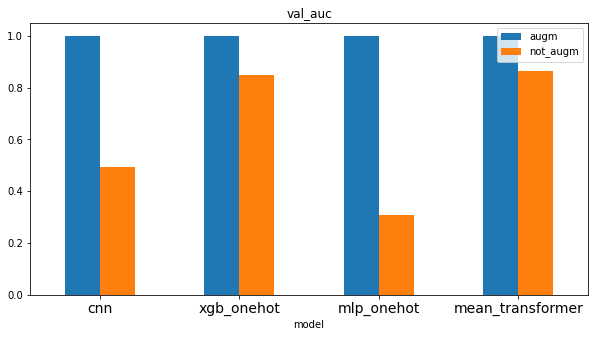

In [7]:
_, val_auc_df, models = baplot_metric(results_df, metric_to_show="val_auc")
val_auc_df

# Model based analysis

In [15]:
import pickle
from nltk.tokenize import wordpunct_tokenize
from src.preprocessors import CommandTokenizer
from src.data_utils import commands_to_loader, create_dataloader
from src.models import (
    CNN1DGroupedModel,
    MeanTransformerEncoder,
    SimpleMLP,
)
from xgboost import XGBClassifier


TOKENIZER = wordpunct_tokenize
VOCAB_SIZE = 4096
EMBEDDED_DIM = 64
MAX_LEN = 128
DATALOADER_WORKERS = 4
BATCH_SIZE = 1024
DEVICE = "gpu"
DROPOUT = 0.5
RANDOM_SEED = 33


def read_teset_set(INFOLDER):
    with open(os.path.join(INFOLDER, "test_cmd.txt"), encoding="utf-8") as f:
        test_cmd = f.readlines()
    X_test_cmds = [x.strip() for x in test_cmd if x.strip() != ""]
    y_test = np.load(os.path.join(INFOLDER, "test_y.npy"))
    return X_test_cmds, y_test

def get_arrays(name):
    vocab_file = f"{name}_wordpunct_vocab_4096.json"

    tokenizer = CommandTokenizer(tokenizer_fn=TOKENIZER, vocab_size=VOCAB_SIZE, max_len=MAX_LEN)
    tokenizer.load_vocab(os.path.join(INFOLDER, vocab_file))

    X_test_cmds, y_test = read_teset_set(INFOLDER)
    X_test_loader = commands_to_loader(X_test_cmds, tokenizer, y=y_test, workers=DATALOADER_WORKERS, batch_size=BATCH_SIZE)

    oh_file = os.path.join(INFOLDER, f"{name}_onehot_{VOCAB_SIZE}.pkl")
    with open(oh_file, "rb") as f:
        oh = pickle.load(f)

    X_test_onehot = oh.transform(X_test_cmds)
    return X_test_onehot, X_test_loader, y_test

loaders = {}
onehots = {}

name = 'augm'
onehots[name], loaders[name], y_test = get_arrays(name)
name = 'not_augm'
onehots[name], loaders[name], y_test = get_arrays(name)

def read_models(infolder):
    models = {}
    for subfolder in os.listdir(INFOLDER):
        # lit models
        if subfolder.endswith("_csv"):
            key = subfolder.replace("_csv", "")
            ckpt_folder = os.path.join(INFOLDER, subfolder, "version_0", "checkpoints")
            best_ckpt = [x for x in os.listdir(ckpt_folder) if x != "last.ckpt"][0]
            best_ckpt = os.path.join(ckpt_folder, best_ckpt)
            models[key] = best_ckpt

        if subfolder.endswith("xgb_onehot"):
            key = subfolder
            best_ckpt = os.path.join(INFOLDER, subfolder, "model.pkl")
            models[key] = best_ckpt
    return models

model_files = read_models(INFOLDER)

In [16]:
model_files

{'augm_cnn': './logs_augm_no_augm/nl2bash/augm_cnn_csv\\version_0\\checkpoints\\epoch=2-tprval_tpr=1.0000-f1val_f1=0.9474-accval_cc=0.0000.ckpt',
 'augm_mean_transformer': './logs_augm_no_augm/nl2bash/augm_mean_transformer_csv\\version_0\\checkpoints\\epoch=3-tprval_tpr=0.2700-f1val_f1=0.1667-accval_cc=0.0000.ckpt',
 'augm_mlp_onehot': './logs_augm_no_augm/nl2bash/augm_mlp_onehot_csv\\version_0\\checkpoints\\epoch=1-tprval_tpr=1.0000-f1val_f1=0.0000-accval_cc=0.0000.ckpt',
 'augm_xgb_onehot': './logs_augm_no_augm/nl2bash/augm_xgb_onehot\\model.pkl',
 'not_augm_cnn': './logs_augm_no_augm/nl2bash/not_augm_cnn_csv\\version_0\\checkpoints\\epoch=0-tprval_tpr=0.0000-f1val_f1=0.0000-accval_cc=0.0000.ckpt',
 'not_augm_mean_transformer': './logs_augm_no_augm/nl2bash/not_augm_mean_transformer_csv\\version_0\\checkpoints\\epoch=0-tprval_tpr=0.2700-f1val_f1=0.0000-accval_cc=0.0000.ckpt',
 'not_augm_mlp_onehot': './logs_augm_no_augm/nl2bash/not_augm_mlp_onehot_csv\\version_0\\checkpoints\\epoch=0-

In [17]:
import torch
from torch import sigmoid
from src.lit_utils import LitTrainerWrapper

test_preds = {}
for name in model_files:
    preds_file = os.path.join(INFOLDER, f"y_test_preds_{name}.npy")
    if os.path.exists(preds_file):
        print(f"[!] Loading {preds_file}")
        y_test_preds = np.load(preds_file)
        test_preds[name] = y_test_preds
        continue

    model_file = model_files[name]
    run_name = "not_augm" if "not_augm" in name else "augm"
    model_type = name.replace(run_name, "").strip("_")
    
    if model_type == "xgb_onehot":
        with open(model_file, "rb") as f:
            model = pickle.load(f)
        y_test_preds = model.predict_proba(onehots[run_name])[:, 1].reshape(-1, 1)
    else:
        # just rebuild model every time
        cnn_model = CNN1DGroupedModel(vocab_size=VOCAB_SIZE, embed_dim=EMBEDDED_DIM, num_channels=32, kernel_sizes=[2, 3, 4, 5], mlp_hidden_dims=[64, 32], output_dim=1, dropout=DROPOUT) # 301 K params
        mean_transformer_model = MeanTransformerEncoder(vocab_size=VOCAB_SIZE, d_model=EMBEDDED_DIM, nhead=4, num_layers=2, dim_feedforward=128, max_len=MAX_LEN, dropout=DROPOUT, mlp_hidden_dims=[64,32], output_dim=1) # 335 K params
        mlp_tab_model_onehot = SimpleMLP(input_dim=VOCAB_SIZE, output_dim=1, hidden_dim=[64, 32], dropout=DROPOUT) # 264 K params
        xgb_model_onehot = XGBClassifier(n_estimators=100, max_depth=10, random_state=RANDOM_SEED)

        models = {
                "xgb_onehot": xgb_model_onehot,
                "mlp_onehot": mlp_tab_model_onehot,
                "mean_transformer": mean_transformer_model,
                "cnn": cnn_model,
            }
        model = models[model_type]

        if "mlp_onehot" in name:
            test_loader = create_dataloader(onehots[run_name], y_test, batch_size=BATCH_SIZE, workers=DATALOADER_WORKERS)
        else:
            test_loader = loaders[run_name]

        lit_trainer = LitTrainerWrapper(model, log_folder="./temp")
        lit_trainer.load_lit_model(model_file)
        _ = lit_trainer.predict_lit_model(loader=test_loader, dump_logits="./temp/a.pkl")
        with open("./temp/a.pkl", "rb") as f:
            y_test_logits = pickle.load(f)
        y_test_preds = sigmoid(torch.vstack(y_test_logits))
        os.remove("./temp/a.pkl")
    test_preds[name] = y_test_preds
    np.save(os.path.join(INFOLDER, f"y_test_preds_{name}.npy"), test_preds[name])


[!] Loading ./logs_augm_no_augm/nl2bash/y_test_preds_augm_cnn.npy
[!] Loading ./logs_augm_no_augm/nl2bash/y_test_preds_augm_mean_transformer.npy
[!] Loading ./logs_augm_no_augm/nl2bash/y_test_preds_augm_mlp_onehot.npy
[!] Loading ./logs_augm_no_augm/nl2bash/y_test_preds_augm_xgb_onehot.npy
[!] Loading ./logs_augm_no_augm/nl2bash/y_test_preds_not_augm_cnn.npy
[!] Loading ./logs_augm_no_augm/nl2bash/y_test_preds_not_augm_mean_transformer.npy
[!] Loading ./logs_augm_no_augm/nl2bash/y_test_preds_not_augm_mlp_onehot.npy
[!] Loading ./logs_augm_no_augm/nl2bash/y_test_preds_not_augm_xgb_onehot.npy


In [18]:
# print number of false positives per model
stats = pd.DataFrame()
model_pattern = "xgb"
for threshold in [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]:
    for name in test_preds:
        if model_pattern not in name:
            continue
        y_test_preds = test_preds[name]
        y_test_preds = y_test_preds > threshold
        y_test_preds = y_test_preds.reshape(-1)
        y_test = y_test.reshape(-1)
        # print(f"{name}: {np.sum(y_test_preds & ~y_test)}")
        stats.loc[name, threshold] = int(np.sum(y_test_preds & ~y_test))
stats

,0.001,0.010,0.050,0.100,0.200,0.300,0.500
augm_xgb_onehot,29.0,15.0,11.0,10.0,6.0,3.0,2.0
not_augm_xgb_onehot,15.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# as above, but for false negatives
stats = pd.DataFrame()
model_pattern = "xgb"
for threshold in [0.3, 0.5, 0.7, 0.8, 0.9]:
    for name in test_preds:
        if model_pattern not in name:
            continue
        y_test_preds = test_preds[name]
        y_test_preds = y_test_preds > threshold
        y_test_preds = y_test_preds.reshape(-1)
        y_test = y_test.reshape(-1)
        # print(f"{name}: {np.sum(y_test_preds & ~y_test)}")
        stats.loc[name, threshold] = int(np.sum(~y_test_preds & y_test))
stats

,0.3,0.5,0.7,0.8,0.9
augm_xgb_onehot,0.0,0.0,0.0,1.0,1.0
not_augm_xgb_onehot,8.0,8.0,9.0,9.0,9.0


In [20]:
# plot roc curves per model: augm '-' and not_augm '--'
def plot_roc_augm_not_aumg(model_pattern, test_preds, y_test, ax=None, color="blue"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    for name in test_preds:
        if model_pattern not in name:
            continue
        y_test_preds = test_preds[name]
        y_test_preds = y_test_preds.reshape(-1)
        y_test = y_test.reshape(-1)
        linestyle = "-." if "not_augm" in name else "-"
        fpr, tpr, _ = roc_curve(y_test, y_test_preds)
        auc = roc_auc_score(y_test, y_test_preds)
        ax.plot(fpr, tpr, label=f"{name} (auc={auc:.3f})", linestyle=linestyle, color=color)

    # ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    return ax

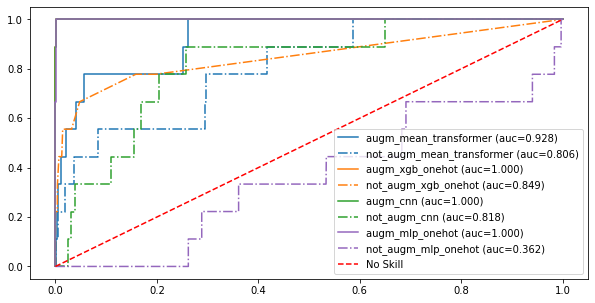

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
# tab colors for 4 models
colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple"]
for color, model_pattern in zip(colors, models):
    ax = plot_roc_augm_not_aumg(model_pattern, test_preds, y_test, ax=ax, color=color)

ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill', color="red")
_ = ax.legend()

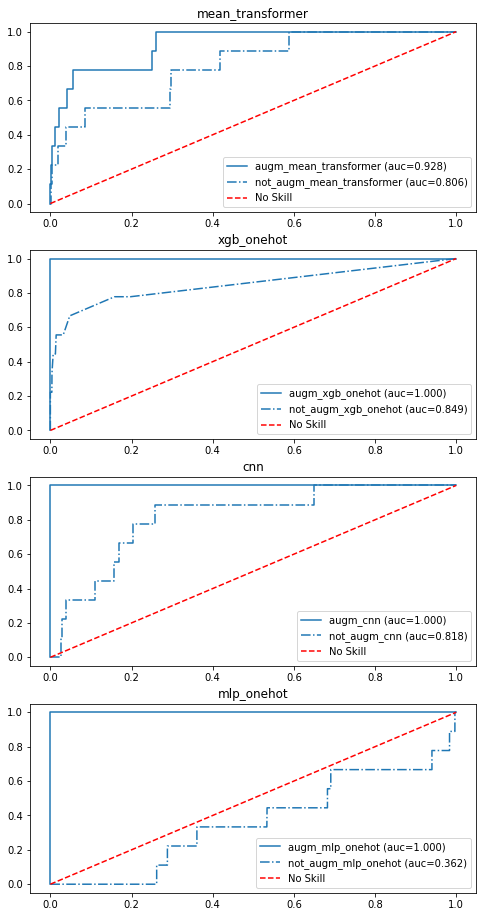

In [31]:
fig, axs = plt.subplots(4, 1, figsize=(8, 16))
for i, model in enumerate(models):
    ax = plot_roc_augm_not_aumg(model, test_preds, y_test, ax=axs[i], color="tab:blue")
    ax.plot([0, 1], [0, 1], linestyle='--', label='No Skill', color='red')
    ax.set_title(model)
    _ = ax.legend()